In [ ]:
 pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 20.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [ ]:
# !pip uninstall -y transformers
# !pip install transformers==4.51.3 --quiet


Found existing installation: transformers 4.40.2
Uninstalling transformers-4.40.2:
  Successfully uninstalled transformers-4.40.2


In [ ]:
# import transformers
# from transformers import TrainingArguments

# print("Transformers version:", transformers.__version__)
# print("TrainingArguments is from:", TrainingArguments.__module__)


Transformers version: 4.51.3
TrainingArguments is from: transformers.training_args


Imports


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch.utils.data import DataLoader
from datasets import Dataset



Load Dataset

In [ ]:
data = pd.read_csv("/content/Combined Data.csv")
data.dropna(inplace=True)
data.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

data

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...
53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53040,Is there any way to sleep better? I can't slee...,Anxiety
53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety


In [ ]:
data =  data.sample(n=6000, random_state=42).reset_index(drop=True)
data

,statement,status
0,I'm lazy to complain about it ba ihh,Normal
1,i think the wifi on my iphone is broken it wil...,Normal
2,Good tracking apps? I've been trying to find a...,Bipolar
3,I have recently looked into reddit and found t...,Depression
4,that's your favorite thing to do?,Normal
...,...,...
5995,What is around you right now? A photo? A comfo...,Depression
5996,I am tired. I am ready for everything to be ov...,Suicidal
5997,? What if I am at a friends party and a man wh...,Stress
5998,if it add any kind of info m almost the thing ...,Depression


Data Preprocessing

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
def clean_statement(statement):
    # Convert to lowercase
    statement = statement.lower()

    # Remove special characters (punctuation, non-alphabetic characters)
    statement = re.sub(r'[^\w\s]', '', statement)

    # Remove numbers (optional, depending on your use case)
    statement = re.sub(r'\d+', '', statement)

    # Tokenize the statement (split into words)
    words = statement.split()

    # Remove stopwords
    words = [word for word in words if word not in stop_words]

    # Rejoin words into a cleaned statement
    cleaned_statement = ' '.join(words)

    return cleaned_statement

# Apply the cleaning function to the 'statement' column
data['statement'] = data['statement'].apply(clean_statement)
data


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,statement,status
0,im lazy complain ba ihh,Normal
1,think wifi iphone broken quot connect quot act...,Normal
2,good tracking apps ive trying find apps track ...,Bipolar
3,recently looked reddit found place actually qu...,Depression
4,thats favorite thing,Normal
...,...,...
5995,around right photo comfortable place sit beaut...,Depression
5996,tired ready everything life pointless painful ...,Suicidal
5997,friends party man whispers ear likes stare tou...,Stress
5998,add kind info almost thing ive always felt kin...,Depression


In [ ]:
data['status'].value_counts()

,count
status,
Normal,1894
Depression,1730
Suicidal,1219
Anxiety,429
Stress,304
Bipolar,293
Personality disorder,131


Balance dataset

In [ ]:
from imblearn.over_sampling import RandomOverSampler
import pandas as pd

# Create an instance of RandomOverSampler
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)

# Define features (X) and target (y)
X = data.drop(columns=['status'])
y = data['status']

# Perform oversampling
X_resampled, y_resampled = ros.fit_resample(X, y)

# Combine the oversampled features and target back into a DataFrame
data = pd.concat([X_resampled, y_resampled], axis=1)

# Check the new class distribution
print(data['status'].value_counts())

status
Normal                  1894
Bipolar                 1894
Depression              1894
Suicidal                1894
Stress                  1894
Personality disorder    1894
Anxiety                 1894
Name: count, dtype: int64


Encoding



In [ ]:
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['status'])

Train test split

In [ ]:
train_texts, test_texts, train_labels, test_labels = train_test_split(data['statement'], data['label'], test_size=0.2)

In [ ]:
max([len(text) for text in data['statement']])

5893

Tokenization

In [ ]:
from transformers import BertTokenizer

# Tokenization using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


train_encodings = tokenizer(list(train_texts), padding=True, truncation=True, max_length=200)
test_encodings = tokenizer(list(test_texts), padding=True, truncation=True, max_length=200)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# train_encodings

In [ ]:
train_dataset = Dataset.from_dict({'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask'], 'labels': train_labels.tolist()})
test_dataset = Dataset.from_dict({'input_ids': test_encodings['input_ids'], 'attention_mask': test_encodings['attention_mask'], 'labels': test_labels.tolist()})


In [ ]:
train_dataset[0]

{'input_ids': [101,
  3110,
  22585,
  10047,
  2428,
  6911,
  2075,
  4485,
  2746,
  10722,
  2229,
  2123,
  2102,
  10587,
  2831,
  2436,
  3208,
  11839,
  2987,
  2102,
  2360,
  4485,
  6047,
  12731,
  2480,
  5665,
  2613,
  3497,
  2360,
  4485,
  2067,
  2292,
  6039,
  4933,
  28667,
  8743,
  9031,
  2831,
  3105,
  5665,
  2707,
  2008,
  2015,
  2123,
  2102,
  2342,
  3331,
  4632,
  3046,
  2532,
  2360,
  3139,
  3649,
  15488,
  2232,
  2643,
  2428,
  2064,
  2102,
  3524,
  2693,
  11839,
  2693,
  17306,
  2361,
  12731,
  2480,
  2123,
  2102,
  10587,
  4902,
  2123,
  2102,
  2342,
  22308,
  3048,
  10047,
  2469,
  10047,
  16986,
  3182,
  4638,
  2214,
  2173,
  4431,
  2428,
  3043,
  2034,
  2333,
  2123,
  2102,
  2228,
  2214,
  2173,
  7039,
  2071,
  3308,
  10657,
  2131,
  4923,
  2978,
  2488,
  3452,
  10047,
  2307,
  16713,
  2295,
  10047,
  14488,
  2488,
  2420,
  12731,
  2480,
  2123,
  2102,
  10587,
  2562,
  8084,
  7149,
  4485,
  102

Fine Model

In [ ]:
print(TrainingArguments)


<class 'transformers.training_args.TrainingArguments'>


In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))



Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# pip install transformers==4.27.0


In [ ]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(label_encoder.classes_)
)

# ——— 2) TrainingArguments (W&B disabled)
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",             # Evaluate at end of each epoch
    save_strategy="epoch",             # Save at end of each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_strategy="steps",
    logging_steps=10,
    lr_scheduler_type="linear",
    warmup_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=3,
    gradient_accumulation_steps=2,
    report_to=["tensorboard"]          # Disable W&B, only TensorBoard logging
)

# ——— 3) Instantiate Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset            # your validation split
)

# ——— 4) Fine-tune
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,1.032300,0.978434
2,0.382600,0.341918
3,0.189400,0.278376
4,0.052100,0.248791


TrainOutput(global_step=1655, training_loss=0.5265362387607465, metrics={'train_runtime': 1990.7031, 'train_samples_per_second': 26.639, 'train_steps_per_second': 0.831, 'total_flos': 5435953984560000.0, 'train_loss': 0.5265362387607465, 'epoch': 4.986425339366516})

                      precision    recall  f1-score   support

             Anxiety       0.97      0.99      0.98       397
             Bipolar       0.98      1.00      0.99       372
          Depression       0.86      0.69      0.77       396
              Normal       0.93      0.90      0.91       353
Personality disorder       0.99      1.00      1.00       379
              Stress       0.95      1.00      0.97       383
            Suicidal       0.77      0.87      0.82       372

            accuracy                           0.92      2652
           macro avg       0.92      0.92      0.92      2652
        weighted avg       0.92      0.92      0.92      2652



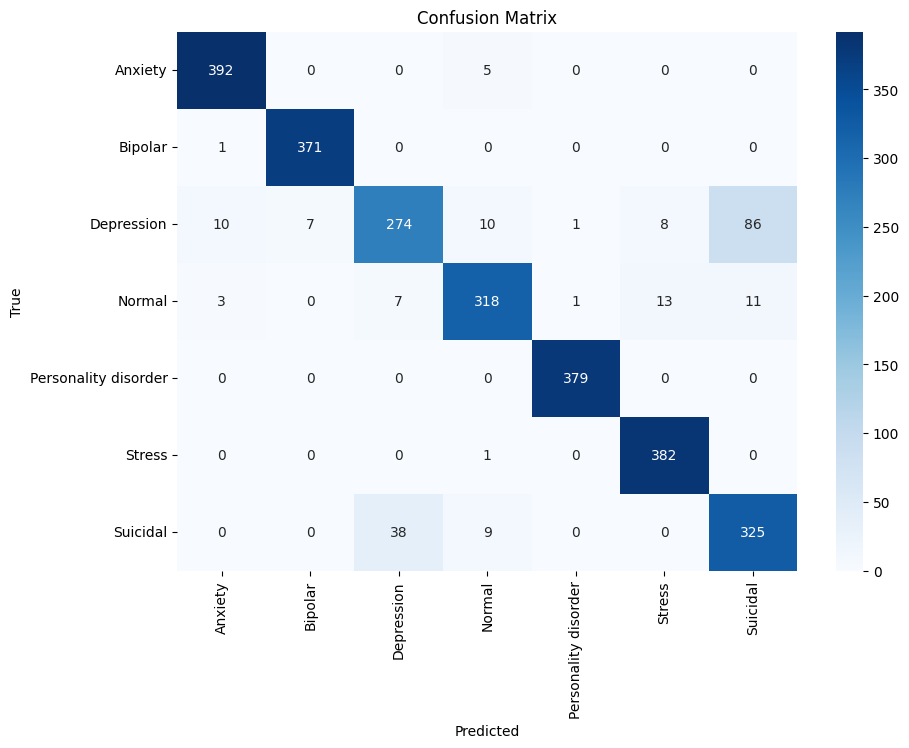

In [ ]:
# Predictions
predictions, labels, _ = trainer.predict(test_dataset)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Classification Report
print(classification_report(test_labels, predicted_labels, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:

# Save the trained model and tokenizer
trainer.save_model("saved_mental_status_bert")  # Save the model to the specified directory
tokenizer.save_pretrained("saved_mental_status_bert")  # Save the tokenizer


import pickle

pickle.dump(label_encoder, open('label_encoder.pkl', 'wb'))


In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load the model and tokenizer from the saved paths
model = AutoModelForSequenceClassification.from_pretrained("saved_mental_status_bert")
tokenizer = AutoTokenizer.from_pretrained("saved_mental_status_bert")

label_encoder = pickle.load(open('label_encoder.pkl', 'rb'))

In [ ]:
# Detection System (Example)
def detect_anxiety(text):
    cleaned_text = clean_statement(text)
    inputs = tokenizer(cleaned_text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    return label_encoder.inverse_transform([predicted_class])[0]

# Test detection system with a mixture of normal, anxiety, bipolar, depression, suicide, etc.
sample_texts = [
    "I feel perfectly fine today, nothing to worry about.",
    "I can't stop thinking about what will happen if things go wrong.",
    "Lately, I've been on a high, feeling like I can do anything!",
    "I'm so sad, I just can't seem to get out of bed anymore.",
    "I'm constantly thinking about how much better everyone else is doing than me.",
    "I don't think I can keep going, everything feels so hopeless.",
    "I had a really good day, spent some time with my friends.",
    "I'm overwhelmed by the idea that I might lose everything.",
    "I feel like nothing matters anymore, I just want to give up.",
    "I'm okay today, but sometimes I get really anxious for no reason."
]

# Assuming the detect_anxiety function is already defined and takes a sentence as input
for text in sample_texts:
    predicted_class = detect_anxiety(text)
    print(f"Sentence: {text}\nPredicted class: {predicted_class}\n")



Sentence: I feel perfectly fine today, nothing to worry about.
Predicted class: Normal

Sentence: I can't stop thinking about what will happen if things go wrong.
Predicted class: Normal

Sentence: Lately, I've been on a high, feeling like I can do anything!
Predicted class: Normal

Sentence: I'm so sad, I just can't seem to get out of bed anymore.
Predicted class: Depression

Sentence: I'm constantly thinking about how much better everyone else is doing than me.
Predicted class: Normal

Sentence: I don't think I can keep going, everything feels so hopeless.
Predicted class: Depression

Sentence: I had a really good day, spent some time with my friends.
Predicted class: Normal

Sentence: I'm overwhelmed by the idea that I might lose everything.
Predicted class: Normal

Sentence: I feel like nothing matters anymore, I just want to give up.
Predicted class: Depression

Sentence: I'm okay today, but sometimes I get really anxious for no reason.
Predicted class: Anxiety



In [ ]:
import shutil
from google.colab import files

# Step 1: Save the trained model and tokenizer
model_save_path = "saved_mental_status_bert"  # Path to save the trained model
tokenizer_save_path = "saved_mental_status_bert"  # Path to save the tokenizer

# Save the model and tokenizer
trainer.save_model(model_save_path)
tokenizer.save_pretrained(tokenizer_save_path)

# Step 2: Create a zip file containing the saved model and tokenizer using shutil
zip_file_path = "saved_mental_status_bert"  # Path for the zip file without extension

# Create a zip archive of the directories
shutil.make_archive(zip_file_path, 'zip', root_dir='saved_mental_status_bert', base_dir='')

# Step 3: Provide a download link to the zip file
files.download(f"{zip_file_path}.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>